# AME16 project

Written by Young-Ho Song, RISP, IBS

Modifed Last: 2019.10.07. 

Most simple version of Neural Network. 
Input : (integer N, integer Z) 
output: (float BE/A) 
training : random choice of training,validation. test set from AME16 data. 


## import packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from read_mass16 import read_mass16

#----Global option variables 
opt_model_load = False
opt_model_save = False 
opt_model_train = True 
model_filename = 'my_model.h5'
opt_data_load = False
opt_data_save = False 
dataset_filenames = ['train_dataset','test_dataset']


# convert integer to array 
def integer_to_bin_array(N,dim_b=8):
    """ Convert integers into dim_b bits  binary
    """
    bin_str = bin(N)[2:] # to binary string 
    if len(bin_str) > dim_b :
        raise ValueError('{} is too large to be {} bits'.format(N,dim_b))
    bin_str=bin_str.zfill(dim_b) #padding zero 
    bin_array=[float(j) for j in bin_str] 
    return bin_array

## load AME16 data

In [2]:
# read data and prepare dataframe 
AME16_dic=read_mass16()
AME16_df=pd.DataFrame.from_dict(AME16_dic) # convert dictionary to pd.DataFrame 

# drop empty data 
AME16_df = AME16_df.dropna()

# atomic mass unit will be used for onversion later 
atomic_mass_unit = 931.4940954 # MeV 

In [7]:
AME16_dic.keys()

dict_keys(['NZ', 'N', 'Z', 'A', 'EL', 'O', 'mass_excess', 'mass_excess_measured', 'mass_excess_unc', 'BE/A', 'BE/A_measured', 'BE/A_unc', 'B', 'beta', 'beta_measured', 'beta_unc', 'atomic_mass', 'atomic_mass_measured', 'atomic_mass_unc', 'N_bits', 'Z_bits'])

## Prepare data: Choose train and test set 

(1) Remove empty/incomplete data 

(2) Choose only A> 10 cases 

(3) radomize

(4) Seprate train set and test set (seperation of training and validation is done later)

,count,mean,std,min,25%,50%,75%,max
NZ,1914.0,22.608673,15.085293,-6.000000,11.000000,21.000000,33.000000,59.000000
N,1914.0,79.689655,37.580439,9.000000,50.000000,80.000000,108.000000,160.000000
Z,1914.0,57.080982,24.293127,9.000000,38.000000,57.000000,78.000000,110.000000
A,1914.0,136.770637,61.459945,18.000000,88.000000,138.000000,186.000000,270.000000
mass_excess,1914.0,-40935.114625,41515.741185,-91652.853000,-72871.343250,-54197.371500,-17407.232500,134834.709000
mass_excess_measured,1914.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mass_excess_unc,1914.0,29.046613,90.744723,0.000490,1.863000,6.744000,18.524000,1336.694000
BE/A,1914.0,8160.138706,367.539071,6614.792000,7872.163000,8209.344000,8458.260750,8794.553000
BE/A_measured,1914.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BE/A_unc,1914.0,0.353962,1.484566,0.000000,0.016000,0.050000,0.129000,23.008000


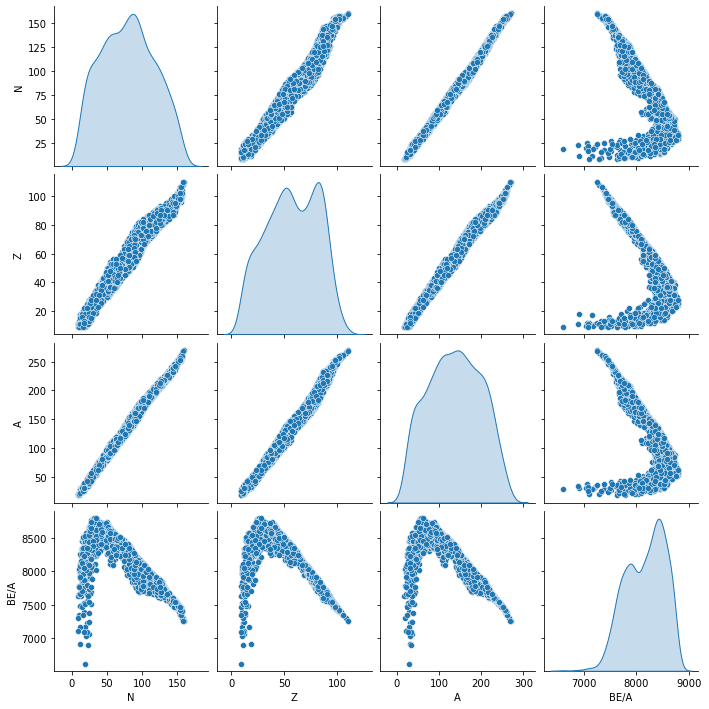

In [7]:
# 1. only take A > 10 cases
AME16_df = AME16_df[ (AME16_df['N']> 8 )&(AME16_df['Z']> 8)] 
#AME16_df = AME16_df[ (AME16_df['A']> 10 )] 
#randomize 
AME16_df = AME16_df.reindex(
    np.random.permutation(AME16_df.index))
# we will use mass_excess as target 

#Separation of train set and test set 
dataset = AME16_df ;
train_dataset = dataset.sample(frac=0.8) ;# train+validation data set  
dataset = dataset.drop(train_dataset.index) #remove train data from dataset 
#validation_dataset = dataset.sample(frac=0.5)
#test_dataset= dataset.drop(validation_dataset.index) 
test_dataset = dataset

#-----save or load data set ---- 
if opt_data_load:
    train_dataset = pd.read_pickle(dataset_filenames[0]  )
    test_dataset = pd.read_pickle(dataset_filenames[1])
if opt_data_save:
    train_dataset.to_pickle(dataset_filenames[0]  )
    test_dataset.to_pickle(dataset_filenames[1])
#----------------------------------------------------------------------
sns.pairplot(train_dataset[["N", "Z","A", "BE/A"]], diag_kind="kde")

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

## Prepare data: Choose features and lables

preprocess_feature : feature engineering

preprocess_targets : target engineering 

norm : normalize data 

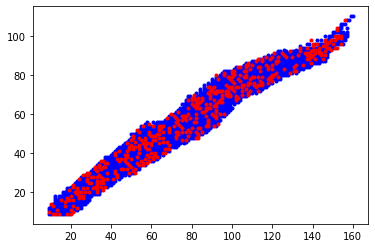

In [8]:
#----------------------------------------------------------------------
#===Preprocess feature and target 
def preprocess_features(data_frame):
  """Prepares input features from California housing data set.

  Args:
    data_frame: A Pandas DataFrame expected to contain data
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
    
    Note: Synthetic features should be encoded here 
  """
  #feature_choices=["N","Z","NZ"]
  feature_choices=["N","Z"]
  selected_features = data_frame[ feature_choices ]
  processed_features = selected_features.copy() # to make symthetic features 
  # Create a synthetic feature.
  #processed_features["Asym"] =  data_frame["NZ"] / data_frame["A"]
  #  integer_to_bin_array(data_fram['N'].values)
  return processed_features

def preprocess_targets(data_frame):
  """Prepares target features (i.e., labels) from data set.
  Args:
    data_frame: A Pandas DataFrame expected to contain data
    target_feature : target feature    
  Returns:
    A DataFrame that contains the target feature.
  """  
  output_targets = pd.DataFrame()
  # Scale the target 
  target_feature="BE/A"
  output_targets[target_feature] = (data_frame[target_feature]/1000.) #to MeV unit
  return output_targets

#=========================================
# Data normalization
# For example, one may normalize such that 
#
# def norm(x):
#  return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)
#
# train_stats['mean']['NZ'] gives the mean of 'NZ' values 
# in this way, each column values are normalized by their means and standard deviations 
#  
train_examples = preprocess_features(train_dataset)
train_labels = preprocess_targets(train_dataset)

test_labels = preprocess_targets(test_dataset)
test_examples = preprocess_features(test_dataset)

#plot nuclear chart 
plt.plot(train_examples["N"],train_examples["Z"],'b.'
         ,test_examples["N"],test_examples["Z"],'r.')

#------
# The data are prepared as pd.DataFrame.
# But one can use tf.data.Dataset. 
# to get array from dataframe one use dataframe.values 
#----------
#train_dataset = tf.data.Dataset.from_tensor_slices( (   train_examples.values, train_labels.values )   )
#test_dataset = tf.data.Dataset.from_tensor_slices( (   test_examples.values, test_labels.values )   )


## Build Model


In [9]:
# print dots per the end of one epoch 
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

#plot history 
def plot_history(history,drop_epoch=0):
  # drop_epoch : remove first a few epochs from the graph   
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MeV]')
  plt.plot(hist['epoch'][drop_epoch:], hist['mean_absolute_error'][drop_epoch:],
           label='Train Error')
  plt.plot(hist['epoch'][drop_epoch:], hist['val_mean_absolute_error'][drop_epoch:],
           label = 'Val Error')
  ymax= np.max(hist['val_mean_absolute_error'][drop_epoch:].to_numpy())
  #plt.ylim([0,5])
  plt.ylim([0,ymax])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MeV^2$]')
  plt.plot(hist['epoch'][drop_epoch:], hist['mean_squared_error'][drop_epoch:],
           label='Train Error')
  plt.plot(hist['epoch'][drop_epoch:], hist['val_mean_squared_error'][drop_epoch:],
           label = 'Val Error')
  ymax= np.max(hist['val_mean_squared_error'][drop_epoch:].to_numpy())  
  plt.ylim([0,ymax])
  plt.legend()
  plt.show()

    #Build Model  
def build_model():
  """
   keras.Sequential makes a Sequential model object
   one can add layers into the model by 
   (1) initialization
   (2) or, add layers by .add method
   
   To compile of model, one have to supply 
   what is the optimizer and loss function
   and what kind of metric will be shown 
   when fitted. 
          
    To recap: here are the most common ways to prevent overfitting in neural networks:
        Get more training data.
        Reduce the capacity of the network.
        (1) Add weight regularization.
        For each layer, one can add regularizers like
      keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation='relu')
        (2) Add dropout.
        add dropout layer 
       keras.layers.Dropout(0.5)
  """  
  model = keras.Sequential([
    layers.Dense(10, activation=tf.nn.relu, input_shape=[2]), 
    layers.Dense(10, activation=tf.nn.relu),  
    layers.Dense(10, activation=tf.nn.relu), # tanh ? 
    layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer = 'adam'
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [21]:
#====Check point and callback 
#Create a tf.keras.callbacks.ModelCheckpoint callback that saves weights only during training:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
# by using this callback one can save model 
# here only weights are stored. Thus, one have to create the model
# with same archietecture to load weights 
# also, one may use different names for check points period=5... 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
## later one may Loads the weights like this 
# model.load_weights(checkpoint_path)
#
#
# instead one can load whole model with weights from a file 
#-------------------------------------------------------------------

if opt_model_load :
  model = tf.keras.models.load_model(model_filename)
  model.summary()
  print(" Old model is loaded !!")   
else :
  model = build_model()
  model.summary()
  print(" New model is created !!")   

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                30        
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________
 New model is created !!


## Train model with data

In [22]:
# early stopping callback ise used to regularize the model fitting
# patience is a number of epochs to check early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# when model fitting, one provides training sets and validation sets 
# or one can split training sets into training and validation. 
import json

def save_history(history,filename): 
    #convert history of fitting into a dictionary and save it 
    import json 
    hist = history.history
    hist['epoch'] = history.epoch 
    for key in hist:
       hist[key] = [float(i) for i in  hist[key]] # because float32 or other is not compatible with pickle 
    #pickle.dump(hist,open(filename,'w'))
    json.dump(hist,open(filename,'w'))
    return 

if opt_model_train:
    print('Training model')  
    EPOCHS = 300
    history = model.fit(train_examples, train_labels , epochs=EPOCHS,
                    batch_size=30,
                    validation_split = 0.3, verbose=0, callbacks=[PrintDot()])
#                    validation_split = 0.3, verbose=1, callbacks=[early_stop, PrintDot()])
#                    validation_split = 0.3, verbose=0, callbacks=[cp_callback, early_stop, PrintDot()])

    #--saving history 
    history_dict = save_history(history,model_filename+'_history')
else:    
    # read previous results of fitting   
    history_dict = json.load(open(model_filename+'_history', 'r'))
    print('Model is loaded and not trained')  

# load model 
#new_model = tf.keras.models.load_model('my_model.h5')

Training model

....................................................................................................
....................................................................................................
....................................................................................................

## Evaluate model 

Mean Abloute Error: 0.05787554383277893
Mean Squared Error: 0.0059257997199893


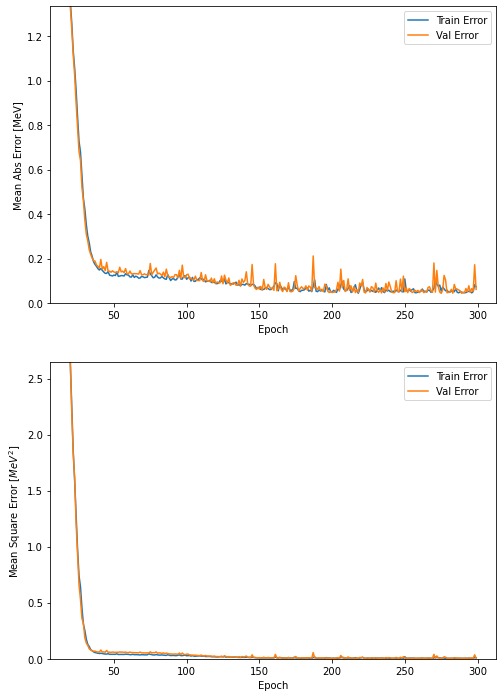

In [23]:
#['mean_absolute_error', 'mean_squared_error']
loss,mae,mse =  model.evaluate(test_examples.values,test_labels.values,verbose=0)
print('Mean Abloute Error:', mae)
print('Mean Squared Error:', mse)
#history 

hist = pd.DataFrame(history.history)

hist['epoch'] = history.epoch
hist.tail()

plot_history(history,drop_epoch=20)


In [24]:
#=====let's save model for later use 
# Instead one may want to save entire model 
# One can save the model with 
if opt_model_save :
   model.save(model_filename)
   print("Model is saved")
# One can Recreate the exact same model, including its weights and the optimizer
#
# new_model = tf.keras.models.load_model('my_model.h5')


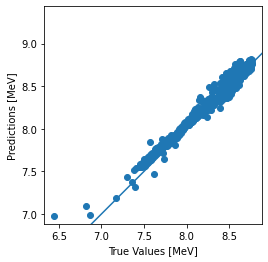

In [25]:
## predict
test_predictions = model.predict(test_examples).flatten()

plt.figure() 
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MeV]')
plt.ylabel('Predictions [MeV]')
plt.axis('equal')
plt.axis('square')

plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100]) # linear line 

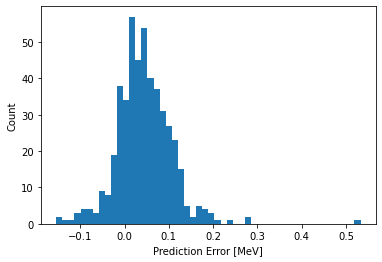

In [26]:
## error distribution
error = test_predictions - test_labels.to_numpy().flatten() 
plt.figure() 
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [MeV]")
_ = plt.ylabel("Count")

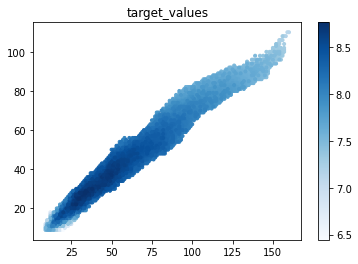

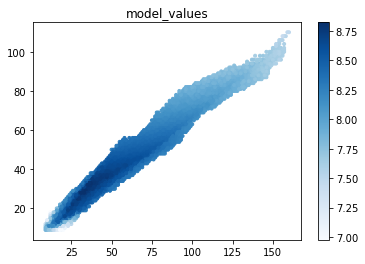

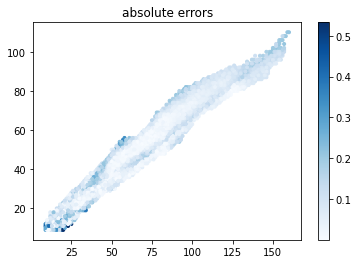

In [27]:
out_test = model.predict(test_examples)
out_train = model.predict(train_examples)

plt.figure()
plt.title('target_values')
plt.scatter(train_examples["N"],train_examples["Z"],
            marker='.',c= train_labels.values.flatten() , cmap=plt.cm.get_cmap('Blues'))
plt.scatter(test_dataset["N"],test_dataset["Z"],
            marker='.',c= test_labels.values.flatten(), cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()

plt.figure()
plt.title('model_values')
plt.scatter(train_examples["N"],train_examples["Z"],
            marker='.',c= out_train.flatten() , cmap=plt.cm.get_cmap('Blues'))
plt.scatter(test_dataset["N"],test_dataset["Z"],
            marker='.',c= out_test.flatten(), cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()

test_errors = out_test - test_labels 
test_errors = np.abs(test_errors.values).flatten()
train_errors = out_train - train_labels
train_errors = np.abs(train_errors.values).flatten()

plt.figure()
plt.title('absolute errors')
plt.scatter(train_examples["N"],train_examples["Z"],
            marker='.',c=train_errors, cmap=plt.cm.get_cmap('Blues'))
plt.scatter(test_examples["N"],test_examples["Z"],
            marker='.',c=test_errors, cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()

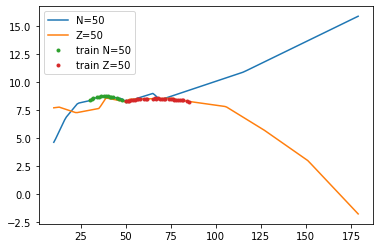

In [28]:
# testing 
N_test = 50
Z_test = 50
predict_test={'N': np.ones(170)*N_test, 'Z': np.arange(10,180) };
predict_test=pd.DataFrame.from_dict(predict_test)
predict_test= preprocess_features(predict_test)
yy = model.predict(predict_test)
plt.plot(predict_test['Z'],yy[:,0],label='N={}'.format(N_test) )

predict_test={'N': np.arange(10,180), 'Z': np.ones(170)*Z_test };
predict_test=pd.DataFrame.from_dict(predict_test)
predict_test= preprocess_features(predict_test)
yy = model.predict(predict_test)
plt.plot(predict_test['N'],yy[:,0],label='Z={}'.format(Z_test) )
plt.legend()

train_x= train_dataset['Z'][ train_dataset['N']==N_test  ]
train_y= (train_dataset['BE/A'][ train_dataset['N']==N_test  ])/(1000.)   
plt.plot(train_x,train_y,'.',label='train N={}'.format(N_test))

train_x= train_dataset['N'][ train_dataset['Z']==Z_test  ]
train_y= (train_dataset['BE/A'][ train_dataset['Z']==Z_test  ])/(1000.)   
plt.plot(train_x,train_y,'.',label='train Z={}'.format(Z_test))

plt.legend()